In [75]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
!pip install poutyne
import numpy as np
import wandb
import os, torch
import matplotlib.pyplot as plt
from torchvision.datasets  import ImageFolder 
from torchvision.transforms import ToTensor
import albumentations
import os
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.optim as Optimizer
from torch import nn
import timm
from poutyne import Model
from poutyne import ModelCheckpoint, CSVLogger, set_seeds
from poutyne.framework import Model, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import torchmetrics
import poutyne
batch_size=128

#### Import Dataset & EDA

In [76]:
# https://pytorch.org/data/main/
dataset_dir ="/kaggle/input/catsvsdogs/dataset/"
print(os.listdir(dataset_dir))
classes = os.listdir(dataset_dir + "/train")
print(classes)

['test', 'train']
['dogs', 'cats']


In [77]:
cat_images=os.listdir(dataset_dir + "train/cats")
print(len(cat_images))
print(cat_images[:5])

8995
['cats8313.jpg', 'cats1019.jpg', 'cats6891.jpg', 'cats3506.jpg', 'cats3720.jpg']


In [101]:
# https://albumentations.ai/docs/examples/pytorch_classification/
class AlbumentationTransform():
    def __init__(self, albumentations_transform):
        self.albumentations_transform=albumentations_transform
    
    def __call__(self, sample):
        image = np.array(sample)
        transformed =self.albumentations_transform(image=image)
        transformed_image= transformed['image']
        return ToTensor()(transformed_image)

In [102]:
image_size = 224
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.RandomBrightness(limit=0.1, p=0.7),
    albumentations.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=10, p=0.5),
    albumentations.RandomBrightnessContrast(0.1, 0.1, p=0.5),
    albumentations.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    albumentations.OneOf([
    albumentations.OpticalDistortion(distort_limit=1.),
    albumentations.GridDistortion(num_steps=5, distort_limit=1.),
    ], p=0.5),
])

train_data = ImageFolder(dataset_dir + "train", transform =AlbumentationTransform(transforms_train))

In [103]:
test_transform = albumentations.Compose(
    [
        albumentations.Resize(image_size, image_size),
    ]
)
test_data = ImageFolder(dataset_dir + "test", transform= AlbumentationTransform(test_transform))

In [81]:
img, label = train_data[0]
print(img.shape, train_data.classes)

torch.Size([3, 224, 224]) ['cats', 'dogs']


In [82]:
def show_images(img, label):
    print("label:", train_data.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

label: cats (0)


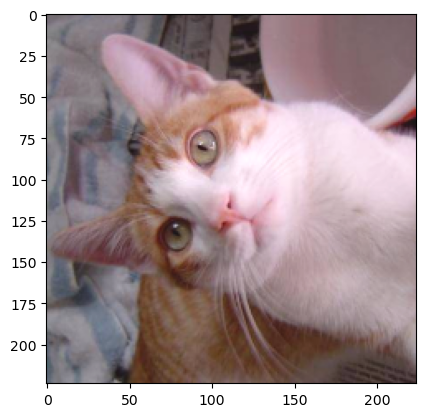

In [16]:
#view from train data
show_images(*train_data[15])

In [ ]:
#show from test data
show_images(*test_data[120])

In [59]:
####training & validaion dataset
random_seed=42
torch.manual_seed(random_seed)

##### Split dataset and load data

In [104]:
val_size = 3500
train_size=len(train_data)- val_size
train_ds, valid_ds = random_split(train_data, [train_size, val_size])

In [105]:
# https://pytorch.org/docs/stable/data.html
train_data=DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_data = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)
test = DataLoader(test_data, batch_size, pin_memory=True)

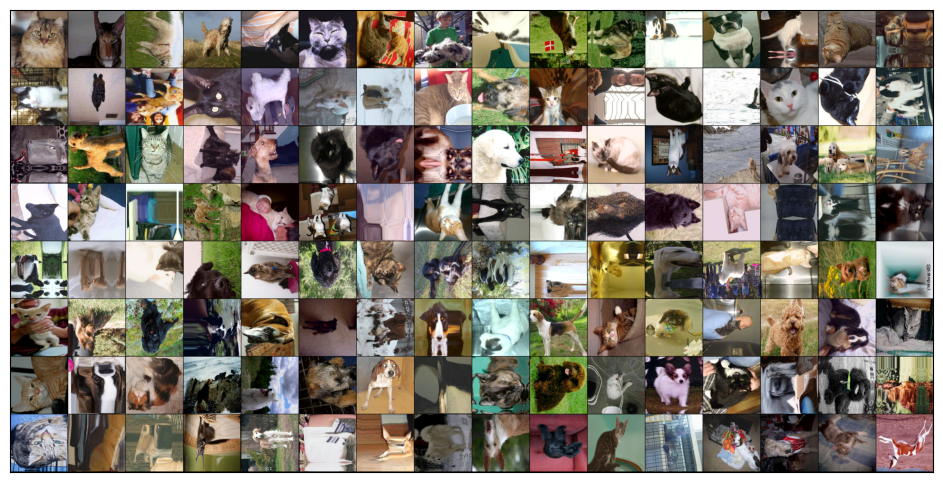

In [106]:
def show_grid(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    plt.show()

show_grid(train_data)

In [97]:
backbone = 'tf_efficientnetv2_b2' 
pretrained=False
drop_rate = 0.
drop_path_rate = 0.
class TimmModel(nn.Module):
    def __init__(self):
        super(TimmModel, self).__init__() #explicilit define can be shorted
        
        self.effnetv2b2=timm.create_model(
            backbone, #which model wanna used
            in_chans=3, #channel number
            features_only=False, #feature with classification header
            drop_rate=drop_rate, 
            drop_path_rate=drop_path_rate,
            pretrained=pretrained,
            num_classes=2,
        )
    def forward(self, x, verbose=True):
        x=self.effnetv2b2(x)
        return x

In [98]:
backbone = 'tf_efficientnetv2_b2' 
pretrained=False
drop_rate = 0.
drop_path_rate = 0.
m=TimmModel()

In [99]:
criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(m.parameters(), lr=0.005)

In [16]:
# wandb_logger =poutyne.WandBLogger(name="A run", project="DogVsCatClassification")
# config_dict = {"Optimizer": "adam", "Loss": "Cross-Entropy", "lr": 0.003}
# wandb_logger.log_config_params(config_params=config_dict)

In [115]:
best_accuracy = 0.0
best_epoch = -1
best_loss = float('inf')
wandb.init(name="Finale_Pretrained", project="DogVsCatClassification")
class WandBEpochCallback(poutyne.Callback):
    def __init__(self):
        super().__init__()
        self.best_accuracy = 0.0
        self.best_epoch = -1
        self.best_loss = float('inf')
    
    def on_epoch_end(self, epoch, logs):
        # Log metrics to WandB for each epoch
        wandb.log({"epoch": epoch + 1,
                   "train_loss": logs['loss'],
                   "train_accuracy": logs['acc'],
                   "val_loss": logs['val_loss'],
                   "val_accuracy": logs['val_acc']})
        # Track best accuracy, best epoch, and best loss
        if logs['val_acc'] > self.best_accuracy:
            self.best_accuracy = logs['val_acc']
            self.best_epoch = epoch + 1
        
        if logs['val_loss'] < self.best_loss:
            self.best_loss = logs['val_loss']

        # Log best accuracy, best epoch, and best loss
        wandb.log({"best_accuracy": self.best_accuracy,
                   "best_epoch": self.best_epoch,
                   "best_loss": self.best_loss})
        
        # Calculate epoch/accuracy and epoch/learning_rate ratios
        epoch_accuracy_ratio = (epoch + 1) / logs['val_acc']
        epoch_learning_rate_ratio = (epoch + 1) / optimizer.param_groups[0]['lr']
        
        # Log epoch/accuracy and epoch/learning_rate ratios
        wandb.log({"epoch_accuracy_ratio": epoch_accuracy_ratio,
                   "epoch_learning_rate_ratio": epoch_learning_rate_ratio})
wandbcallback=WandBEpochCallback()

epoch,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
epoch,2
train_accuracy,58.13851
train_loss,0.72745
val_accuracy,62.62857
val_loss,0.65446


In [113]:
checkpoint_dir = "/kaggle/working/models/"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_filepath = os.path.join(checkpoint_dir, "model_checkpoint_{epoch:02d}.pth")
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    mode="min",          
    save_best_only=False,
    verbose=True
)

In [ ]:
class UploadCheckpointToGCS(Callback):
    def __init__(self, checkpoint_dir, bucket_destination):
        self.checkpoint_dir = checkpoint_dir
        self.bucket_destination = bucket_destination

    def on_epoch_end(self, trainer, pl_module):
        for filename in os.listdir(self.checkpoint_dir):
            if filename.startswith("model_checkpoint"):
                checkpoint_filepath = os.path.join(self.checkpoint_dir, filename)
                gsutil_command = f"gsutil -mq cp {checkpoint_filepath} {self.bucket_destination}"
                subprocess.run(gsutil_command, shell=True)
                print(f"{checkpoint_filepath} saved in the bucket")
os.makedirs(checkpoint_dir, exist_ok=True)
bucket_destination = "gs://tibot-ml-labeling/models/cats_vs_dogs_task/gaju/Eff_Not_pretrained//model/"
upload_callback = UploadCheckpointToGCS(checkpoint_dir, bucket_destination)

In [91]:
log_dir = "/kaggle/working/models"
os.makedirs(log_dir, exist_ok=True)
csv_logger = CSVLogger(os.path.join(log_dir, 'log.tsv'), separator='\t')

In [107]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Model(m, optimizer, criterion ,epoch_metrics=['accuracy'], device=device) 

In [116]:
model.fit_generator(train_data, valid_data, epochs=20, callbacks=[checkpoint_callback, csv_logger,upload_callback, wandbcallback])

Epoch:  1/20 Train steps: 114 Val steps: 28 2m9.21s loss: 0.690313 acc: 63.919945 val_loss: 0.639938 val_acc: 65.057143
Epoch 1: saving file to /kaggle/working/models/model_checkpoint_01.pth
Epoch:  2/20 Train steps: 114 Val steps: 28 1m54.42s loss: 0.685680 acc: 64.258109 val_loss: 0.627533 val_acc: 65.971429
Epoch 2: saving file to /kaggle/working/models/model_checkpoint_02.pth
Epoch:  3/20 Train steps: 114 Val steps: 28 2m5.82s loss: 0.634292 acc: 65.486542 val_loss: 0.617421 val_acc: 67.457143
Epoch 3: saving file to /kaggle/working/models/model_checkpoint_03.pth
Epoch:  4/20 Train steps: 114 Val steps: 28 2m5.91s loss: 0.659458 acc: 66.659765 val_loss: 0.643359 val_acc: 68.200000
Epoch 4: saving file to /kaggle/working/models/model_checkpoint_04.pth
Epoch:  5/20 Train steps: 114 Val steps: 28 2m6.33s loss: 0.619329 acc: 66.818496 val_loss: 0.595189 val_acc: 68.428571
Epoch 5: saving file to /kaggle/working/models/model_checkpoint_05.pth
Epoch:  6/20 Train steps: 114 Val steps: 28 

[{'epoch': 1,
  'time': 129.20993312600012,
  'loss': 0.6903128034908909,
  'acc': 63.91994478529778,
  'val_loss': 0.6399378399167742,
  'val_acc': 65.05714286150251},
 {'epoch': 2,
  'time': 114.41521000300008,
  'loss': 0.6856803269654492,
  'acc': 64.25810903229329,
  'val_loss': 0.6275331766945975,
  'val_acc': 65.97142854527064},
 {'epoch': 3,
  'time': 125.8197110430001,
  'loss': 0.6342915924192709,
  'acc': 65.48654243463973,
  'val_loss': 0.6174208780016218,
  'val_acc': 67.45714283970425},
 {'epoch': 4,
  'time': 125.91220004099978,
  'loss': 0.659457764747309,
  'acc': 66.65976535647059,
  'val_loss': 0.6433587138312203,
  'val_acc': 68.20000006103515},
 {'epoch': 5,
  'time': 126.33499045099961,
  'loss': 0.6193288379080795,
  'acc': 66.81849551204158,
  'val_loss': 0.5951889117785862,
  'val_acc': 68.42857141113281},
 {'epoch': 6,
  'time': 127.91591979799978,
  'loss': 0.5900669606246974,
  'acc': 69.19944790352451,
  'val_loss': 0.5958269839968,
  'val_acc': 67.68571425

In [117]:
import pandas as pd
logs =pd.read_csv("/kaggle/working/models/log.tsv", sep='\t')
bes_epoch_ids =logs['val_acc'].idxmax()  
best_epoch = int(logs.loc[bes_epoch_ids]['epoch'])

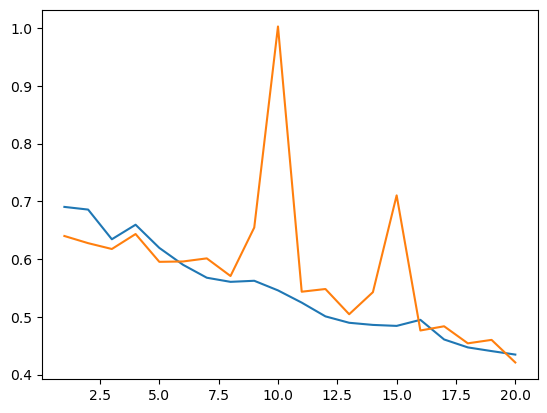

In [118]:
import matplotlib.pyplot as plt
metrics = ['loss', 'val_loss']
plt.plot(logs['epoch'], logs[metrics])
plt.show()

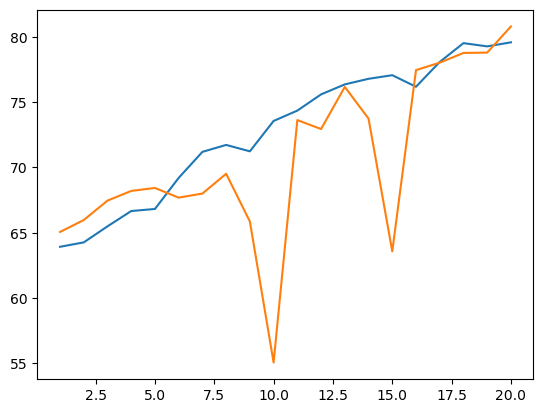

In [119]:
metrics = ['acc', 'val_acc']
plt.plot(logs['epoch'], logs[metrics])
plt.show()

In [120]:
loss, acc= model.evaluate_generator(test)
loss, acc

Test steps: 37 53.25s test_loss: 0.448776 test_acc: 79.860524                  


(0.44877599455598843, 79.86052409774251)

In [121]:
all_true_labels = []
for batch_data, batch_labels in test:
    all_true_labels.extend(batch_labels.tolist())
predictions=model.predict_generator(test, steps=len(test))
predicted_labels =[np.argmax(prediction) for prediction in predictions]

Prediction steps: 37 20.74s                                           


In [122]:
class_labels = test.dataset.classes
classification_rep = classification_report(all_true_labels, predicted_labels, target_names=class_labels)
print("/n",classification_rep)

/n               precision    recall  f1-score   support

        cats       0.96      0.76      0.85      3505
        dogs       0.57      0.91      0.70      1227

    accuracy                           0.80      4732
   macro avg       0.76      0.83      0.77      4732
weighted avg       0.86      0.80      0.81      4732



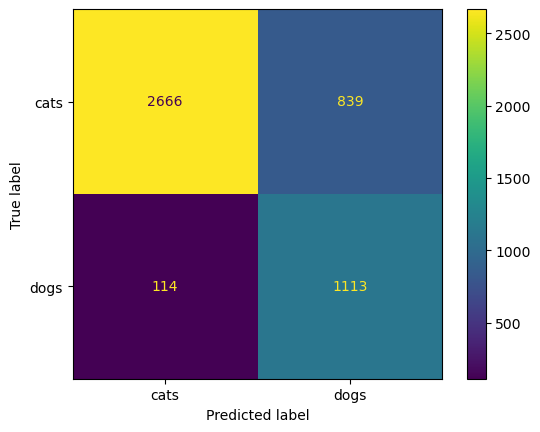

In [123]:
cm = confusion_matrix(all_true_labels, np.array(predicted_labels))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=class_labels)
cm_display.plot()
plt.show()

In [124]:
wandb.finish()

best_accuracy,▁▁▂▂▂▂▂▃▃▃▅▅▆▆▆▇▇▇▇█
best_epoch,▁▁▂▂▂▂▂▄▄▄▅▅▅▅▅▇▇▇██
best_loss,██▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▂▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_accuracy_ratio,▁▁▂▂▃▃▄▄▅▆▅▆▆▆█▇▇▇██
epoch_learning_rate_ratio,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▂▂▂▃▄▄▄▅▆▆▇▇▇▆▇███
train_loss,██▆▇▆▅▅▄▄▄▃▃▃▂▂▃▂▁▁▁
val_accuracy,▄▄▄▅▅▄▅▅▄▁▆▆▇▆▃▇▇▇▇█
val_loss,▄▃▃▄▃▃▃▃▄█▂▃▂▂▄▂▂▁▁▁
best_accuracy,80.8


#### Pret-trained Model with Weights

In [125]:
pretrained=True
drop_rate = 0.
drop_path_rate = 0.
m_weights=TimmModel()

In [127]:
criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(m_weights.parameters(), lr=0.005)

In [128]:
log_dir = "/kaggle/working/weights/"
os.makedirs(log_dir, exist_ok=True)
csv_logger = CSVLogger(os.path.join(log_dir, 'log.tsv'), separator='\t')

In [129]:
checkpoint_dir = "/kaggle/working/weights/"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_filepath = os.path.join(checkpoint_dir, "model_checkpoint_{epoch:02d}.pth")
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    mode="min",          
    save_best_only=False,
    verbose=True
)

In [ ]:
bucket_destination = "gs://tibot-ml-labeling/models/cats_vs_dogs_task/gaju/Efff_pretrained/model/"
upload_callback = UploadCheckpointToGCS(checkpoint_dir, bucket_destination)

In [130]:
wandb.init(name="Finale_Pretrained_weights", project="DogVsCatClassification")
wandbcallback=WandBEpochCallback()

wandb: Currently logged in as: gajuahmd. Use `wandb login --relogin` to force relogin


In [131]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_1 = Model(m_weights, optimizer, criterion ,epoch_metrics=['accuracy'], device=device) 

In [132]:
model_1.fit_generator(train_data, valid_data, epochs=20, callbacks=[checkpoint_callback, upload_callback,csv_logger, wandbcallback])

Epoch:  1/20 Train steps: 114 Val steps: 28 1m58.43s loss: 0.902910 acc: 69.316770 val_loss: 0.562484 val_acc: 72.457143
Epoch 1: saving file to /kaggle/working/weights/model_checkpoint_01.pth
Epoch:  2/20 Train steps: 114 Val steps: 28 1m51.68s loss: 0.444522 acc: 79.040718 val_loss: 0.350785 val_acc: 83.828571
Epoch 2: saving file to /kaggle/working/weights/model_checkpoint_02.pth
Epoch:  3/20 Train steps: 114 Val steps: 28 1m52.37s loss: 0.347315 acc: 84.485852 val_loss: 0.288228 val_acc: 87.828571
Epoch 3: saving file to /kaggle/working/weights/model_checkpoint_03.pth
Epoch:  4/20 Train steps: 114 Val steps: 28 1m53.18s loss: 0.306322 acc: 86.701173 val_loss: 0.284113 val_acc: 87.228571
Epoch 4: saving file to /kaggle/working/weights/model_checkpoint_04.pth
Epoch:  5/20 Train steps: 114 Val steps: 28 1m54.76s loss: 0.287629 acc: 87.563837 val_loss: 0.258933 val_acc: 88.428571
Epoch 5: saving file to /kaggle/working/weights/model_checkpoint_05.pth
Epoch:  6/20 Train steps: 114 Val s

[{'epoch': 1,
  'time': 118.42519603900018,
  'loss': 0.9029100527674515,
  'acc': 69.31677018212318,
  'val_loss': 0.5624841168948582,
  'val_acc': 72.45714283098494},
 {'epoch': 2,
  'time': 111.68256576000022,
  'loss': 0.4445220863432453,
  'acc': 79.04071773847602,
  'val_loss': 0.3507845687866211,
  'val_acc': 83.82857144601005},
 {'epoch': 3,
  'time': 112.36557453100068,
  'loss': 0.3473148066187991,
  'acc': 84.48585231825761,
  'val_loss': 0.28822787359782626,
  'val_acc': 87.8285713849749},
 {'epoch': 4,
  'time': 113.17547137899965,
  'loss': 0.3063220219417964,
  'acc': 86.70117321870013,
  'val_loss': 0.28411273966516765,
  'val_acc': 87.22857145472935},
 {'epoch': 5,
  'time': 114.76283835199956,
  'loss': 0.2876292996607294,
  'acc': 87.56383712273617,
  'val_loss': 0.2589326356649399,
  'val_acc': 88.42857138497489},
 {'epoch': 6,
  'time': 118.20426893500007,
  'loss': 0.2312354140019647,
  'acc': 90.30365769706816,
  'val_loss': 0.4290979258673532,
  'val_acc': 82.54

In [172]:
import pandas as pd
logs =pd.read_csv("/kaggle/working/weights/log.tsv", sep='\t')
bes_epoch_ids =logs['val_acc'].idxmax()  
best_epoch = int(logs.loc[bes_epoch_ids]['epoch'])

In [133]:
loss, acc= model_1.evaluate_generator(test)
loss, acc

Test steps: 37 25.06s test_loss: 0.236770 test_acc: 90.976331                  


(0.2367701238337731, 90.97633140609109)

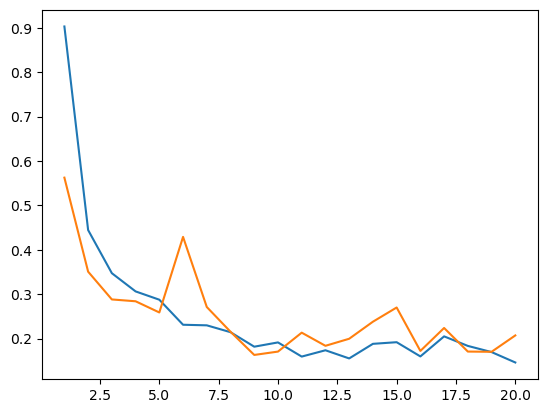

In [174]:
import matplotlib.pyplot as plt
metrics = ['loss', 'val_loss']
plt.plot(logs['epoch'], logs[metrics])
plt.show()

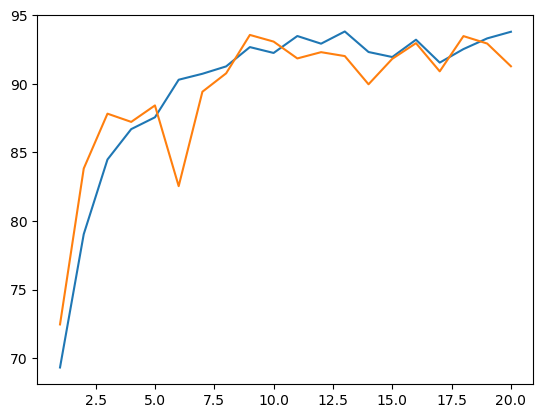

In [173]:
metrics = ['acc', 'val_acc']
plt.plot(logs['epoch'], logs[metrics])
plt.show()

In [135]:
all_true_labels = []
for batch_data, batch_labels in test:
    all_true_labels.extend(batch_labels.tolist())
predictions=model_1.predict_generator(test, steps=len(test))
predicted_labels =[np.argmax(prediction) for prediction in predictions]

Prediction steps: 37 21.04s                                           


In [136]:
class_labels = test.dataset.classes
classification_rep = classification_report(all_true_labels, predicted_labels, target_names=class_labels)
print("/n",classification_rep)

/n               precision    recall  f1-score   support

        cats       1.00      0.88      0.94      3505
        dogs       0.75      0.99      0.85      1227

    accuracy                           0.91      4732
   macro avg       0.87      0.94      0.89      4732
weighted avg       0.93      0.91      0.91      4732



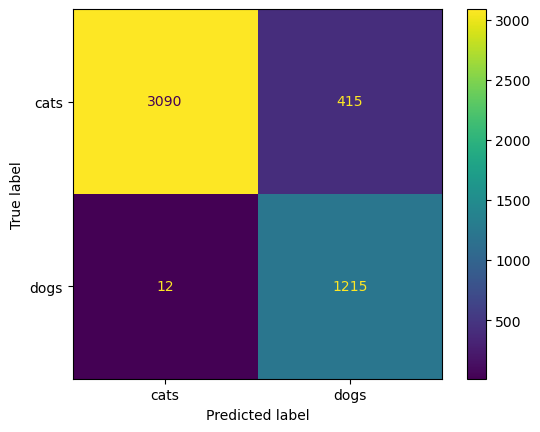

In [137]:
cm = confusion_matrix(all_true_labels, np.array(predicted_labels))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=class_labels)
cm_display.plot()
plt.show()

In [138]:
wandb.finish()

best_accuracy,▁▅▆▆▆▆▇▇████████████
best_epoch,▁▂▃▃▅▅▆▇████████████
best_loss,█▄▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_accuracy_ratio,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█
epoch_learning_rate_ratio,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▆▆▇▇▇██████▇█▇███
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁
val_accuracy,▁▅▆▆▆▄▇▇██▇█▇▇▇█▇██▇
val_loss,█▄▃▃▃▆▃▂▁▁▂▁▂▂▃▁▂▁▁▂
best_accuracy,93.57143


#### Lets import the best model

In [165]:
checkpoint_path = "/kaggle/working/weights/model_checkpoint_10.pth"  # Provide the path to the saved checkpoint file
state_dict = torch.load(checkpoint_path)
m_weights.load_state_dict(state_dict)
m_weights.to("cuda",dtype=torch.float32)
model_2 = Model(m_weights, optimizer=None,loss_function=None) 
model_2.to("cuda")
predict=model_2.predict_generator(test, steps=len(test))
predict_labels =[np.argmax(pred) for pred in predict]

In [171]:
class_rep = classification_report(all_true_labels, predict_labels, target_names=class_labels)
print("/n",class_rep)

/n               precision    recall  f1-score   support

        cats       0.99      0.91      0.95      3505
        dogs       0.78      0.98      0.87      1227

    accuracy                           0.93      4732
   macro avg       0.89      0.94      0.91      4732
weighted avg       0.94      0.93      0.93      4732



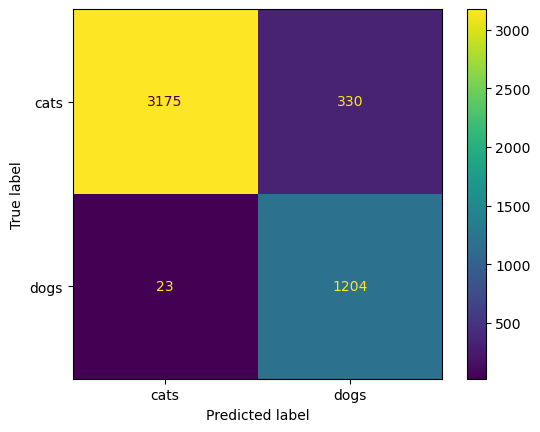

In [170]:
cm = confusion_matrix(all_true_labels, np.array(predict_labels))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=class_labels)
cm_display.plot()
plt.show()

#### Workflow of Poutyne Image Classification

In this task, Done Image classification in a tricky way. Already told about the dataset creation in previous task so in this task do classification on that dataset. Used timm library from pytorch and apply one pretrained model with and without weights and save model after complete each epoch on google drive and google cloud bucket.

Poutyne is basically a little and smothe framework from pytorch here can train any model with less code than pytorch, everyone think that it like keras on pytorch. It have all the method and parameter and extention that shoud have a better model. It have experiment manager like mlflow, wandb and customize metrics and difference training segment.


##### EDA

In EDA segment, basically do little bit EDA like checking image size and other feature.First import image using os then used torch imagefolder for extract image with transform version and also tensor. Before going forward I want to thanks `Albumentations`, Excellent image augmentation library I used here, Its best because it a single interface to work with different computer vision tasks such as classification, semantic segmentation, instance segmentation, object detection, pose estimation.

Did some as usual image augmentation like Horzintal and vertical flip, Transpose, RadomBrightNess and Contrast to image visuality and shft of RGB and two types of distortion then lastly convert into tensor and load with dataloader with the batxh_size of 128 and 2 workers use for process those data. but note that on Test_set there is No augmentation just generall resize used.


#### Model: 
Already Mentioned that here will applied transfer learning, used just one model with and without weights. Lets just reveal the model name which is `EfficientNetv2-B2. This model basically an updated version of efficientNet where some issues and those are adressed here. Like go more further to increase training speed and  parameter efficiency. For both model used same epoch and learning rate and used cross_entropy and adam optimizer with 0.005 learning_rate.

#### Difference Call Back function

**Wandb** Used wandb here as experiment manager and check the parameters and loss and different epoch. Wandb is basically one of the best experiment manager with great visuality. Here I try to focus best loss and best valid and accuracy from all epoch.

**Model checkpoints and save Drive** Here save model on drive and local_envitonment. Basically save the whole model on drive also kaggle and main part is google cloud bucket from notebook. After completing each epoch model automaticaly save two directory.

**CSV Logger** For normal tracking loss and accuracy I implement here another callback function which is csv_logger it track the loss and acc for each epoch and visualized this after training.

All four callback function are called from the training portion to execute and it well better.

#### 
Lets discuss the loss and accuracy of each model, First check the training and validation part then will see the what happend on unseen data.

| Model| Accuracy |loss|
| ----- | ----- |-----|
|EfficinetNetV2-B2-Weights| 93.802|0.14629|
|EfficinetNetV2-B2-Random_weights|80.8|0.434|

Conclusion: Nice task very happy to complete, Faced some complexity on poutyne model intragration and training also on  introduced multiple callback function to the model pipeline and finally complete. 
